In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf

import gpflow
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.base import Parameter
from gpflow.utilities.ops import difference_matrix
from gpflow.kernels.base import Kernel
from gpflow.kernels.stationaries import IsotropicStationary, Stationary

from typing import List, Optional, Union

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import  GridSpec
import matplotlib.dates as dates
from matplotlib.dates import date2num, num2date
from datetime import datetime
dates.set_epoch("1969-01-01T00:00")

import ipywidgets as widgets
from IPython.display import display

%matplotlib nbagg

In [3]:
pd.read_csv("birthdates-1968-1988.csv")

,year,month,day,births,day_of_year,day_of_week
0,1969,1,1,8486,1,3
1,1969,1,2,9002,2,4
2,1969,1,3,9542,3,5
3,1969,1,4,8960,4,6
4,1969,1,5,8390,5,7
...,...,...,...,...,...,...
7300,1988,12,27,11528,362,2
7301,1988,12,28,11847,363,3
7302,1988,12,29,11704,364,4
7303,1988,12,30,11837,365,5


In [4]:
data = pd.read_csv("birthdates-1968-1988.csv")

day_of_week = np.array(data.day_of_week, dtype="float64").reshape(7305, 1)
day_of_year = np.array(data.day_of_year, dtype="float64").reshape(7305, 1)
k = 7
l = 1
for i in range(7500):
    day_of_week = np.append(day_of_week, k)
    day_of_year = np.append(day_of_year, l)
    k += 1
    l += 1
    if k == 8:
        k = 1
    if l == 366:
        l = 1
    
weekends = 1 * np.add(day_of_week == 6, day_of_week == 7) 

weekdays = np.add(day_of_week == 1, day_of_week == 2) 
weekdays = np.add(weekdays, day_of_week == 3)
weekdays = np.add(weekdays, day_of_week == 4)
weekdays = 1 * np.add(weekdays, day_of_week == 5)


Xlist = [i for i in range(1, 7306, 1)]
X = np.array(Xlist, dtype="float64").reshape(7305, 1)

Y = data["births"]
ybar = np.mean(Y)
s = np.std(Y)

Y = np.array((Y - ybar) / s).reshape(7305, 1)

data = (X, Y)
N = len(X)

M = 100
idx = [int(i) for i in list(np.linspace(0, N, M, endpoint=False))]
Z = X[idx, :].copy()

minibatch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

In [5]:
days = np.add(day_of_year == 1, day_of_year == 60)
days = np.add(days, day_of_year == 186)
days = np.add(days, day_of_year == 153)
days = np.add(days, day_of_year == 260)
days = np.add(days, day_of_year == 327)
days = np.add(days, day_of_year == 332)
days = 1 * np.add(days, day_of_year == 360)

In [6]:
class WDaysPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
    
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)

    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        Ix = tf.gather_nd(tf.constant(weekdays), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekdays), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K   

class WEndsPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(weekends), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekends), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

class DayOfYearPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(days), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(days), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

## Modelo

In [117]:
k1 = gpflow.kernels.SquaredExponential(0.2, 260)  # long trend
k2 = gpflow.kernels.SquaredExponential(0.01, 30)  # short trend
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(2, 0.8), 7) * gpflow.kernels.SquaredExponential(0.5, 2000) #
k4 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(0.2, 0.2), 365.25) * gpflow.kernels.SquaredExponential(1, 1000)
k5 = WDaysPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)  # weekday
k6 = WEndsPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)
k7 = DayOfYearPeriodic(gpflow.kernels.SquaredExponential(1, 5000), 365.25)
k8 = gpflow.kernels.SquaredExponential(1, 1200) # 0.005
k9 = gpflow.kernels.White(0.01)

kernel = k1 + k2 + k3 + k4 + k5 + k6 + k7 + k8 + k9
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, whiten=True, num_data=N)

gpflow.set_trainable(m.kernel.kernels[2].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[3].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[4].period, False)
gpflow.set_trainable(m.kernel.kernels[5].period, False)
gpflow.set_trainable(m.kernel.kernels[6].period, False)
gpflow.set_trainable(m.inducing_variable, True)

<IPython.core.display.Javascript object>


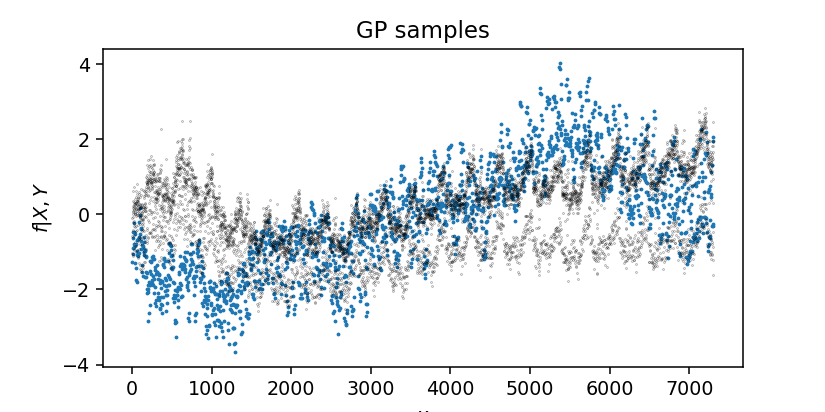

In [118]:
# Genera muestras a priori para testear el kernel

Xt = np.round_(np.linspace(0, 7305, 2000)).astype(np.float64)[:, None]
num_samples = ci_niter(1)
f = m.predict_f_samples(Xt, num_samples)

plt.figure(figsize=(6,3))
for i in range(0, num_samples):
    plt.plot(Xt, f[i, :, :], ".", alpha=1, markersize=2)

plt.plot(X, Y, "k.", alpha=0.5, markersize=0.5)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("GP samples")

plt.show()

In [119]:
def run_adam(model, iterations):
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)  
    optimizer = tf.optimizers.Adam()
    
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            print(step, elbo)
            logf.append(elbo)
    print(step, -training_loss().numpy())
    return logf

In [120]:
maxiter = ci_niter(100000)
logf = run_adam(m, maxiter)

0 -29806.452169117525
10 -27103.12278854303
20 -24635.224497863026
30 -23516.789784445176
40 -22290.395393946892
50 -21123.792133873416
60 -21535.35990891001
70 -20194.459464896798
80 -20552.309746373543
90 -19158.40434063448
100 -18919.724383179295
110 -19317.539446929917
120 -18609.16965715213
130 -18818.330093832083
140 -17880.147080357274
150 -17664.692380354907
160 -17497.213658912267
170 -17267.93267148397
180 -17320.391650464855
190 -17128.863730736717
200 -16582.352738263256
210 -16977.310502211356
220 -16330.691502753776
230 -16270.799477557752
240 -16300.979664744389
250 -15844.569602456193
260 -15994.719485122667
270 -16126.484340182737
280 -15436.094087940352
290 -15614.529414405708
300 -15490.14240738528
310 -15378.400659427425
320 -15410.095179652988
330 -14823.308099167214
340 -15313.513542244616
350 -15036.895689706245
360 -14679.82380636336
370 -14852.2421330602
380 -14598.717273364962
390 -14590.456918314412
400 -14231.644879389074
410 -14322.785561406781
420 -14506.6

3430 -6930.247748617544
3440 -6869.24953120441
3450 -6971.001623519681
3460 -6794.031602005286
3470 -6912.846050747395
3480 -7084.021868948053
3490 -6872.189134663673
3500 -6837.415683512678
3510 -7102.310353341934
3520 -6737.710967962239
3530 -7267.5275345341925
3540 -6462.624459117155
3550 -6750.28527970525
3560 -6816.301396055801
3570 -6620.768499766204
3580 -6826.826079645803
3590 -6436.412397746466
3600 -6480.718242236933
3610 -6682.051894681027
3620 -6626.9791395682805
3630 -6496.982705968409
3640 -6431.034117275631
3650 -6401.16897867676
3660 -6341.773922443841
3670 -6218.241283894061
3680 -6413.021892989565
3690 -6869.689876781978
3700 -6264.382858857974
3710 -6811.440994898537
3720 -6279.242354230245
3730 -6531.609992827653
3740 -6237.828719107782
3750 -6386.767301078223
3760 -6476.57309028341
3770 -6291.097079819478
3780 -6048.072121462851
3790 -6354.568603303491
3800 -6268.771488450381
3810 -6070.95065931707
3820 -6091.695815043935
3830 -5986.40177234462
3840 -6264.740817329

6820 -2845.336126317632
6830 -2749.8797651950335
6840 -3133.9949958045772
6850 -2682.2296682923607
6860 -3675.1318203378114
6870 -2912.0752587393836
6880 -2321.986500013491
6890 -3396.715666237575
6900 -2518.1612111064633
6910 -2234.938059803092
6920 -2403.210601445975
6930 -2856.1758094231805
6940 -1846.5102848356664
6950 -1533.0623475272712
6960 -2462.652836992899
6970 -2011.718261653418
6980 -3697.7763345852777
6990 -3233.1591158550764
7000 -2384.5315550422497
7010 -2115.2418205337904
7020 -2510.085072006856
7030 -2441.393975985821
7040 -2254.784734734303
7050 -2343.1982159753825
7060 -3805.2891440667295
7070 -3721.459049069266
7080 -3455.600522010809
7090 -2298.091348564653
7100 -2544.8165975184297
7110 -3312.977868230901
7120 -2107.6292424372823
7130 -3121.92176244232
7140 -3308.4105832720657
7150 -3830.6433822132703
7160 -2311.948089200109
7170 -2532.9240642647874
7180 -1945.951964538796
7190 -5189.517872390594
7200 -2870.3510021815773
7210 -3700.684452042627
7220 -2913.512197710

10180 -1787.2966958010818
10190 -4112.59500503328
10200 -2204.611327624106
10210 -2424.8692977758024
10220 -1831.4334652301602
10230 -2849.1751652776197
10240 -3128.396005214295
10250 -1449.8962533490876
10260 -2784.2310159071453
10270 -1994.040619541438
10280 -1927.0605543172323
10290 -2854.3369140801747
10300 -2083.949832150618
10310 -2166.0048069475847
10320 -2725.542765421036
10330 -1158.4315122510125
10340 -2576.2004011649033
10350 -1456.6763502567533
10360 -1354.859917989787
10370 -3577.0022101288655
10380 -3377.354723222486
10390 -2145.8368517716044
10400 -1659.3888659308775
10410 -2212.471060624833
10420 -2315.1655277503824
10430 -2458.2445128910904
10440 -2654.0812998055544
10450 -2572.964112045081
10460 -1818.1349456984294
10470 -1234.33819653734
10480 -2067.628992186943
10490 -2198.5243601134807
10500 -3105.623827408359
10510 -2928.6489388047858
10520 -3345.4781527744094
10530 -3561.8947468880915
10540 -1690.6925790901519
10550 -1577.6491492852354
10560 -3671.182281849122
10

13400 -3194.351183711298
13410 -1668.7761466336347
13420 -998.5466573219975
13430 -2332.0372807234035
13440 -2480.981786313083
13450 -2570.0227113064598
13460 -1536.8544096000355
13470 -1841.4695859389683
13480 -1440.18214820139
13490 -3160.0213267965587
13500 -2469.9700254969966
13510 -2081.4866472908952
13520 -4265.953604575334
13530 -2467.464129423143
13540 -3114.8091532761982
13550 -1708.8618777069044
13560 -1563.3482614661864
13570 -1002.1478249091039
13580 -2105.3445728949473
13590 -2089.7237090020626
13600 -1748.24679864052
13610 -1784.0758944168838
13620 -939.9590756627458
13630 -2021.277331035373
13640 -1710.3601087461395
13650 -2726.0589018074793
13660 -555.4026876051862
13670 -1699.638896682146
13680 -1571.6643613223025
13690 -1554.1779904917512
13700 -1935.8121995251634
13710 -1077.332986204029
13720 -2710.40216711803
13730 -4098.754732611513
13740 -690.9551744739042
13750 -2556.2344949253634
13760 -1363.3135666930577
13770 -1865.099196633116
13780 -2882.445713368496
13790 

16620 -1875.9916515870718
16630 -1733.7242264622935
16640 -1982.99529172106
16650 -2191.6693165291235
16660 -1874.1710936243403
16670 -1052.6763191739574
16680 -1848.7839783461668
16690 -1514.59202342454
16700 -2693.7020797153473
16710 -1675.9230217948075
16720 -2230.5810235524964
16730 -1422.4679542577878
16740 -2637.5616609978533
16750 -2191.843530214991
16760 -2939.245991535295
16770 -3614.0468301568244
16780 -1921.9802711097948
16790 -1619.6347300712164
16800 -1470.7657246111557
16810 -2052.451792639128
16820 -1389.147112267883
16830 -1966.0014176131792
16840 -3803.4993470120967
16850 -1630.9685190167359
16860 -2040.951931687261
16870 -3427.333048953142
16880 -2640.1031402991225
16890 -4436.66319191918
16900 -1360.8015216426206
16910 -3342.007816310562
16920 -1385.4955124485755
16930 -1854.4226835279492
16940 -1272.3679731373857
16950 -3168.585068539975
16960 -560.2291967349623
16970 -2201.277017305007
16980 -1490.501865941462
16990 -1686.5303849135312
17000 -3099.6027558864685
170

19840 -1247.4024927290786
19850 -1071.2630646341095
19860 -2486.804973883155
19870 -3186.8962067894677
19880 -1868.5219381948023
19890 -1864.9090060411247
19900 -2066.0681282407136
19910 -1005.6154827734175
19920 -3316.1110568646777
19930 -1455.325765645486
19940 -1158.8544681342523
19950 -2528.8133818544247
19960 -1303.2035111968892
19970 -2439.6387003653044
19980 -3122.5045532009412
19990 -1316.774993001104
20000 -2335.979403396098
20010 -1451.6155850881441
20020 -1623.2688092043684
20030 -3142.8044019635154
20040 -1199.3819887859659
20050 -2281.380952711569
20060 -2243.807259837522
20070 -2192.1815184791594
20080 -2134.6896729404957
20090 -2006.194163117469
20100 -1675.9952623071813
20110 -1579.0331255727178
20120 -1225.2537309211061
20130 -965.4764740943298
20140 -1847.8032661367051
20150 -2785.5193970657306
20160 -3065.25150467047
20170 -1847.7830564549863
20180 -1379.6238820237381
20190 -852.8780061399999
20200 -1839.2406946458862
20210 -3426.668948513877
20220 -625.2533744818821

23060 -2962.2955479989764
23070 -1914.9025794471436
23080 -838.0492377245264
23090 -2309.5583800125787
23100 -2080.3274201042764
23110 -1755.5115355539008
23120 -2693.457594273296
23130 -1961.685260643854
23140 -756.3544171309782
23150 -1100.5964712379146
23160 -1788.2587014155315
23170 -1163.7878880072583
23180 -1412.774839540587
23190 -2595.9033541507833
23200 -2115.65152187438
23210 -1887.2222015676248
23220 -3551.9552614209747
23230 -2369.732115385711
23240 -1072.5619163755714
23250 -1417.2176263710396
23260 -908.2732873311656
23270 -2077.6372431799405
23280 -820.9970992978294
23290 -2276.9617546711675
23300 -3916.7983839965186
23310 -4494.316625161985
23320 -2309.6619001161143
23330 -1680.1898032373608
23340 -2642.2192388376975
23350 -2394.851171395215
23360 -1430.8628109117801
23370 -2462.449885459774
23380 -1622.0051385744594
23390 -2042.1360124219946
23400 -55.429619010281584
23410 -964.7136676166373
23420 -2773.584209507426
23430 -1614.2548140501106
23440 -2021.7633757575743
2

26300 -1481.299954516518
26310 -2450.6982541714156
26320 -1996.5746677473437
26330 -2974.7197858259524
26340 -2167.5037508276564
26350 -1671.7126807825211
26360 -3005.141709409134
26370 -1747.2448218546958
26380 -1350.3191455354035
26390 -977.1560100066146
26400 -3502.0425162675347
26410 -3668.4646998428584
26420 -1976.845463498635
26430 -2541.585186427163
26440 -2255.7974780499203
26450 -3289.5403594255727
26460 -1699.1723946692516
26470 -2182.2800446738775
26480 -2306.8686779814866
26490 -2273.8111238150154
26500 -1460.324312139105
26510 -2427.445407164677
26520 -2046.3469532645006
26530 -1633.8240279281874
26540 -3071.0780262623102
26550 -1479.920726524813
26560 -1678.517830372528
26570 -2344.9910166885393
26580 -1203.2691038539376
26590 -2411.1121835059976
26600 -1789.4156661712366
26610 -2315.232153721301
26620 -1951.916650628545
26630 -900.8924797992375
26640 -2706.687118942103
26650 -1437.6017040101008
26660 -1822.9958105863602
26670 -3514.0019234248516
26680 -2903.96209482391
2

29530 -1720.2515583216873
29540 -1811.1007701344843
29550 -1060.3277481402868
29560 -1521.5680450084978
29570 -1226.5419958193627
29580 -1777.748909564305
29590 -2878.0389254435227
29600 -1808.0295304244667
29610 -639.0715539550204
29620 -2401.493630493578
29630 -3507.1852617747622
29640 -3629.521145181809
29650 -995.8044403022263
29660 -2639.9642255872236
29670 -2652.4052431635137
29680 -2824.3182716202964
29690 -2215.4473246214807
29700 -2236.6578645994473
29710 -2829.578737407837
29720 -2234.642393963838
29730 -3378.0365000356132
29740 -3522.0876852737915
29750 -517.7754235533905
29760 -2244.2648184648933
29770 -1513.9983634399866
29780 -3980.1780560204957
29790 -1196.2234680319068
29800 -1214.0702908964554
29810 -3765.8179541644504
29820 -2300.141931611627
29830 -2766.141225801268
29840 -3466.247017979439
29850 -1598.307513319671
29860 -1273.1726672903071
29870 -2108.769143667073
29880 -3453.95218161997
29890 -2395.4064970949007
29900 -2270.935743681802
29910 -2744.636714866675
299

32740 -2328.5274165133505
32750 -1095.9848121779673
32760 -2187.428027781637
32770 -807.6355193073493
32780 -2180.3426934532417
32790 -2451.6434719968934
32800 -1088.222696819118
32810 -2950.3034322649537
32820 -1443.7716046317814
32830 -908.4434254676428
32840 -1769.121969369248
32850 -1685.6763127362838
32860 -2211.127337159941
32870 -2289.7362289431076
32880 -2035.123556933419
32890 -3410.8049053763148
32900 -2028.4152185699527
32910 -618.8800388614573
32920 -1996.4286777662778
32930 -1757.3138627980366
32940 -909.9668249674655
32950 -3105.960954339307
32960 -2731.2076348343426
32970 -3401.775645831619
32980 -1128.4129492843083
32990 -2850.4723070152245
33000 -1293.325358421456
33010 -3351.204713723907
33020 -2273.5376287740287
33030 -3161.163148312497
33040 -2382.749345630848
33050 -2615.0659372360215
33060 -1379.6750203000306
33070 -3360.2633426897537
33080 -2081.8189757424866
33090 -2755.4798460139864
33100 -4154.968736867439
33110 -2167.3530243297196
33120 -2265.359022184308
331

35970 -2008.2884125809014
35980 -4362.806772635329
35990 -1495.0343145787886
36000 -1985.7611992981783
36010 -1600.4555295504388
36020 -2218.147639957409
36030 -2686.437558255144
36040 -1291.8446651587578
36050 -3314.9857466885787
36060 -2134.5297816041852
36070 -1002.6643099668689
36080 -1370.7349355901288
36090 -1979.090830785289
36100 -3292.3424052994046
36110 -3942.9531363323613
36120 -2988.6657747320546
36130 -3474.007224024272
36140 -1995.5750037571959
36150 -1629.750925057937
36160 -1672.163149400864
36170 -2397.792300510379
36180 -2476.1708881867344
36190 -1081.9320892011576
36200 -1407.9201270940569
36210 -3033.066080589258
36220 -2598.0152343841423
36230 -2450.025026615339
36240 -2764.3697648067923
36250 -2214.2824743849737
36260 -1284.4383256980002
36270 -1636.9228783719122
36280 -2227.6774337398
36290 -3584.5386718369436
36300 -363.8840409462948
36310 -2025.6679331148366
36320 -1003.3868183043572
36330 -2384.861301249968
36340 -1928.994366295862
36350 -864.3323765405308
363

39190 -2175.5605647306124
39200 -2496.683351026546
39210 -1297.4148634561775
39220 -1379.7892261681252
39230 -2094.769928439076
39240 -2710.855520856791
39250 -2176.9372222847596
39260 -1765.2935184745156
39270 -1773.4318539374694
39280 -2666.038249977461
39290 -2902.999356271015
39300 -2283.3039373407896
39310 -1959.032979382087
39320 -1816.8613436385813
39330 -1597.7582111061074
39340 -1526.8483408047396
39350 -2151.926340765638
39360 -1638.1721615014499
39370 -3346.2597963357466
39380 -2264.591739896266
39390 -1276.6776119761016
39400 -695.2775416584408
39410 -3160.8210200837498
39420 -673.3783513965551
39430 -3123.226627146984
39440 -1166.5269460249517
39450 -1224.6692615351042
39460 -1987.2629060943486
39470 -703.5136376473131
39480 -1619.881982085269
39490 -2121.815634511121
39500 -1319.4996551381914
39510 -1918.9099595038124
39520 -1682.3048342321665
39530 -1492.38957132528
39540 -2595.714286377186
39550 -2292.9645308754466
39560 -2680.68678827251
39570 -697.5617727331794
39580 

42410 -596.3972565760466
42420 -1681.5890346718318
42430 -2165.8068790953394
42440 -2672.830998026923
42450 -1142.1024259794312
42460 -2133.289370935172
42470 -1750.9700896172985
42480 -1931.9766751099578
42490 -2939.0714106770047
42500 -930.3836817805684
42510 -2384.6293472779307
42520 -2654.5980178876953
42530 -2756.7273346284346
42540 -1135.4516384129493
42550 -3381.59407851339
42560 -1251.6594161013156
42570 -1424.485215841707
42580 -2253.375878685126
42590 -846.2539735743566
42600 -2756.266465230314
42610 -1327.1449298075852
42620 -1963.2302138693144
42630 -3005.673628587394
42640 -1903.704386861756
42650 -2910.7151653118476
42660 -2239.6702452393224
42670 -3130.9453271484567
42680 -2100.6065390139975
42690 -2494.031124308033
42700 -2871.967180982127
42710 -2125.2565842505533
42720 -3142.0301973504575
42730 -1933.48588145057
42740 -3260.552439859478
42750 -1935.948118887465
42760 -3436.9954283722213
42770 -1079.800586766929
42780 -1282.128426412741
42790 -1625.08070210797
42800 -4

45660 -2281.2042750938026
45670 -1942.3846777687963
45680 -1664.075212947802
45690 -2261.2361348990044
45700 -1986.0737838286022
45710 -1019.0881560532243
45720 -1772.7360529245911
45730 -1840.8830009070834
45740 -2098.58408830259
45750 -2128.9455922717525
45760 -1363.6237955244924
45770 -1266.1910497608158
45780 -2841.098134478125
45790 -1603.3576122239494
45800 -1652.7791848515794
45810 -1252.2350736216224
45820 -1617.9648130189696
45830 -3061.1232687961947
45840 -1013.4098434441287
45850 -2050.664700654726
45860 -2238.7520997149613
45870 -2010.7576867934786
45880 -1949.2828802611716
45890 -1285.0494046667482
45900 -926.5762618373209
45910 -1610.1683402706121
45920 -3280.137181318178
45930 -2235.2806510271453
45940 -1922.8422946452915
45950 -3875.361247051361
45960 -1930.8606687418312
45970 -2943.305180117665
45980 -758.8511946192162
45990 -2147.765618592348
46000 -358.163524825781
46010 -848.467143920904
46020 -1433.41046380732
46030 -1918.5327736136503
46040 -1368.157427069781
4605

48870 -1051.9372507973412
48880 -1343.3850117302782
48890 -3996.956509123047
48900 -3295.7496260281546
48910 -2166.92925624503
48920 -1912.1169371408919
48930 -956.6697147841363
48940 -1370.274760037777
48950 -2379.2472449468664
48960 -2620.5433264932
48970 -803.5373416826858
48980 -3434.424606066677
48990 -1948.0992201093802
49000 -1468.2932229644978
49010 -2022.7347666742726
49020 -1180.6598365033024
49030 -215.8898892061567
49040 -1089.8915159487542
49050 -2432.597878014485
49060 -2012.0368249318371
49070 -2637.2392053816193
49080 -2077.7571026846363
49090 -1915.473124076247
49100 -1477.973858268206
49110 -3301.901915894616
49120 -1958.7727049877606
49130 -1862.7202236879998
49140 -1160.6990255715643
49150 -1127.2301451346887
49160 -1071.371832929783
49170 -1695.5544476756036
49180 -3060.6205783942655
49190 -910.3452371476895
49200 -1249.4547407936475
49210 -1033.9376191699346
49220 -2114.233957475152
49230 -1647.2203699472977
49240 -3364.3983171596424
49250 -1609.5057516327574
4926

52090 -3486.9322503339704
52100 -1446.7864126717855
52110 -2082.9772900626945
52120 -2559.509180067272
52130 -1105.3068013021125
52140 -2745.9123511831885
52150 -2931.1731326070385
52160 -1692.8596177163188
52170 -2237.6937057300347
52180 -1191.9889389567757
52190 -1073.4128602960986
52200 -2261.4945722269467
52210 -4476.255848574789
52220 -3150.3853207164207
52230 -910.3437233704785
52240 -2247.65582081874
52250 -2584.195792673984
52260 -2131.9987672931757
52270 -279.1662285287612
52280 -1208.1087024348724
52290 -1602.6944797565814
52300 -1122.513295263236
52310 -416.76596552875066
52320 -3321.7586949897063
52330 -2245.7054539174833
52340 -1645.227029937761
52350 -431.58451314444187
52360 -3093.1237479678057
52370 -1711.902863516421
52380 -1489.6334543177768
52390 -2102.381011059975
52400 -5040.02149345938
52410 -844.2316112835917
52420 -1095.8004359222584
52430 -2566.6205678240476
52440 -2545.820421624113
52450 -5677.966267243369
52460 -2140.414669703698
52470 -2085.231280459972
5248

55320 -1306.8376769737142
55330 -1871.984640791076
55340 -2067.8741178539753
55350 -2592.633136854973
55360 -1563.354234859099
55370 -1818.928029774811
55380 -2642.3172243804
55390 -2907.935866942218
55400 -566.3797226006656
55410 -1219.6483485822469
55420 -1997.3142195167823
55430 -874.720209531392
55440 -1797.7653387685534
55450 -1610.0210551268278
55460 -3775.0471162670356
55470 -1380.9626591667507
55480 -2106.639725469557
55490 -2457.0972718096955
55500 -957.6564725841381
55510 -1401.444305085629
55520 -2239.6580392461933
55530 -2653.2340920980887
55540 -1125.3864497384602
55550 -1984.7363428968583
55560 -1409.2424967260804
55570 -3296.1879933173263
55580 -1533.8318794755833
55590 -1469.7147760271005
55600 -3456.976750357353
55610 -2225.629817121519
55620 -2957.500828611361
55630 -3525.4524819092417
55640 -1497.7272212838673
55650 -1988.722284453557
55660 -781.8478616274017
55670 -1612.9302198637238
55680 -1838.2163931833456
55690 -2388.011403264042
55700 -1951.7075612104159
55710 

58530 -1143.855019908935
58540 -794.0157182546573
58550 -2542.986859129729
58560 -2135.541655364698
58570 -1695.4642936188338
58580 -768.6296445177692
58590 -1329.6035339314597
58600 -3637.774403113311
58610 -1757.342155168741
58620 -2864.326474792119
58630 -2452.9637794783553
58640 -1691.6781148071336
58650 -3445.2686565662552
58660 -2018.4114999232138
58670 -2380.361235697038
58680 -1460.4860654461763
58690 -1247.2202483796127
58700 -1524.2376313776988
58710 -2191.1391801742993
58720 -545.5083038111575
58730 -2631.330772666025
58740 -1774.7862380333281
58750 -3665.3429961685138
58760 -2118.8531776287405
58770 -3405.094815255866
58780 -3068.256804101713
58790 -1878.3675711862743
58800 -1799.847990594849
58810 -1411.7693609679109
58820 -3099.4276098817736
58830 -1182.001006161176
58840 -1565.310622718422
58850 -534.243101936381
58860 -3528.0624416586134
58870 -1344.9868557846103
58880 -2849.983266661475
58890 -1375.4772110216893
58900 -2354.6449640626524
58910 -2761.66659360719
58920 -

61760 -552.5808038523264
61770 -4448.310655874381
61780 -3733.323373665063
61790 -2063.1399570338913
61800 -2917.690966926411
61810 -2167.450221354137
61820 -3095.48656156473
61830 -1496.1312624319153
61840 -589.7100347391089
61850 -1857.37368952982
61860 -295.5051750558657
61870 -1317.9879959540542
61880 -1573.6705189183194
61890 -1305.544710759992
61900 -1367.8207511316696
61910 -3284.8586063444172
61920 -1099.9963780376745
61930 -1209.921580444388
61940 -345.09624348656575
61950 -1912.675521390993
61960 -823.0343071475431
61970 -2922.885209815803
61980 -2535.0768611347517
61990 -2003.478031846945
62000 -2768.787432470808
62010 -1748.2054701165969
62020 -1818.6675140682853
62030 -1888.7365156190972
62040 -2101.983244162052
62050 -437.41381225977614
62060 -980.3775361229982
62070 -1038.1719080467976
62080 -2437.6070101655096
62090 -1138.5508845736936
62100 -2883.1247059558996
62110 -1529.9049003381306
62120 -1633.5653634592072
62130 -1794.033822275446
62140 -1691.6902239520982
62150 -

64980 -2360.3733649148226
64990 -985.7197715787689
65000 -2812.9921073595037
65010 -3596.391186838394
65020 -1833.7945179981807
65030 -3000.105381403569
65040 -1254.238099961362
65050 -1120.4792921861854
65060 -3954.172143803918
65070 -548.1322343323102
65080 -2085.2694843658674
65090 -1029.4773250565183
65100 -2293.8080938208577
65110 -2735.5957888587322
65120 -2199.259435257686
65130 -1279.898334200329
65140 -3461.6701402881677
65150 -1430.9467427681932
65160 -3653.4574542787827
65170 -1447.6705062091987
65180 -2710.3391977389233
65190 -2122.0035480100514
65200 -2630.132297035398
65210 -2277.0881945752003
65220 -2818.3661499670907
65230 -2615.1041623854594
65240 -2871.9758888721312
65250 -3405.7073548790627
65260 -1090.8589008411714
65270 -2368.0263911312845
65280 -1875.6242923138138
65290 -1046.1936983871778
65300 -2530.335480193763
65310 -1312.9439132167338
65320 -3497.8777132943283
65330 -1032.2777934611718
65340 -1767.4974193700994
65350 -2655.4225800526006
65360 -2764.7120236776

68190 -2157.9792698346273
68200 -2221.2133399910795
68210 -1391.9160895440782
68220 -2655.518793764655
68230 -2222.210379452488
68240 -2335.8288691733446
68250 -2632.323915244301
68260 -1280.7608706868987
68270 -1679.2129981162925
68280 -2634.690278333336
68290 -2785.0242563099805
68300 -1184.54447544497
68310 -661.0495363047542
68320 -2153.993117553685
68330 -2417.257743373489
68340 -1573.714072050813
68350 -2246.0250556332203
68360 -1525.5313025249432
68370 -2610.421383804068
68380 -1818.2099472630528
68390 -2706.6058705090704
68400 -1598.257490854945
68410 -2319.191768122505
68420 -1448.4604054897602
68430 -2662.952985603427
68440 -1545.556156452647
68450 -1990.2972024158876
68460 -1807.8716993574149
68470 -2003.039602310738
68480 -2503.7805171106393
68490 -1082.20365381901
68500 -1665.4948476146253
68510 -2886.593267915802
68520 -2403.179488581075
68530 -1054.5462483034746
68540 -1518.5392057801073
68550 -2266.661475329354
68560 -2076.4307504166704
68570 -806.1577572208237
68580 -1

71410 -1116.3597735089743
71420 -1473.915358403051
71430 -1164.4705182233063
71440 -1482.7515128697976
71450 -1471.7489622595556
71460 -1928.9720066762811
71470 -3732.933464446551
71480 -808.5241290309034
71490 -3686.54215810044
71500 -1236.3323886326452
71510 -1571.3330292321352
71520 -4668.198917423218
71530 -2212.594762532469
71540 -1456.570369633056
71550 -1768.6667562467328
71560 -1699.7958466862167
71570 -1194.5786858226606
71580 -1532.2433291473428
71590 -2020.0622437022507
71600 -1788.053093644447
71610 -1776.9666518154845
71620 -2624.577099191955
71630 -2141.900025643897
71640 -2069.615687969901
71650 -1816.8694653577318
71660 -2211.452136851409
71670 -685.0629768150934
71680 -999.5165179796145
71690 -2288.319753917637
71700 -1786.8751775381436
71710 -2119.254800117063
71720 -1661.6618604828382
71730 -824.0818790481853
71740 -1836.3992087291933
71750 -943.0215353809601
71760 -1696.611835868701
71770 -2471.394767583066
71780 -2799.6895617765913
71790 -2013.18663682183
71800 -20

74640 -3129.438047671747
74650 -934.6519460190812
74660 -2120.3263027069056
74670 -481.48852257245267
74680 -1652.9864066127668
74690 -1468.885807266103
74700 -1795.7699216457079
74710 -2512.343533290869
74720 -1136.5898775499643
74730 -1065.7968346289538
74740 -3411.505440201768
74750 -997.8908572900368
74760 -4879.949325782581
74770 -1622.171322732047
74780 -2243.9070687650815
74790 -2788.7036849407136
74800 -365.410651264883
74810 -3221.6867758446087
74820 -1490.70547652697
74830 -2065.4707914098585
74840 -2512.8050566595357
74850 -1913.2865471944745
74860 -3146.790668488008
74870 -1162.9012954931459
74880 -1129.365233388587
74890 -2877.0941608513863
74900 -1399.2934773930792
74910 -1533.6401803206734
74920 -2143.4220221648475
74930 -2836.4147556865655
74940 -2128.3248945093346
74950 -1074.9307295374506
74960 -2368.9829909118735
74970 -3689.934501427416
74980 -906.1982658634464
74990 -2590.6348910765187
75000 -2519.035947940009
75010 -1713.6617259215186
75020 -1376.448421577311
7503

77860 -923.0169986257526
77870 -739.1867592057642
77880 -1890.3984801776191
77890 -1928.9564548864068
77900 -1732.361292025278
77910 -2036.6297012063103
77920 -1898.3606042630736
77930 -1723.332585345037
77940 -1530.292113880433
77950 -716.729429794613
77960 -2781.8686212482753
77970 -192.8411202319723
77980 -2622.676452756781
77990 -282.97202871265335
78000 -2387.9511122800036
78010 -2605.185343729601
78020 -2150.6023875128885
78030 -1898.5843521503655
78040 -1452.632735748374
78050 -1051.6132079888132
78060 -1240.0646592167725
78070 -457.6229844808304
78080 -2554.424691922397
78090 -1781.2544156463312
78100 -268.2952369584086
78110 -1185.9147449566156
78120 -2067.992169437141
78130 -1208.2702007203534
78140 -1803.5103698931132
78150 -1320.5919215292952
78160 -2961.80684846082
78170 -744.5042165697294
78180 -974.420574032104
78190 -1691.6143662133554
78200 -1187.3388393946952
78210 -3006.065415961057
78220 -1054.8292566425544
78230 -1736.4433748520587
78240 -2042.5050587133414
78250 -

81070 -2660.9072803678546
81080 -2263.3068905518157
81090 -1653.7206189889018
81100 -2052.235477397533
81110 -2811.044974199892
81120 -1626.8944245377668
81130 -444.311186356211
81140 -1935.2999183682778
81150 -496.65911123925014
81160 -2468.976325595575
81170 -3015.439007236892
81180 -1606.1881428667543
81190 -1139.2219179748713
81200 -1389.5330474281982
81210 -448.73953526171346
81220 -948.6884488921828
81230 -1699.1913604611957
81240 -3147.976901264775
81250 -767.436591764863
81260 -2233.3667463727957
81270 -2272.3002897351907
81280 -2659.534320459954
81290 -1623.1505749258747
81300 -1121.1615968546703
81310 -1498.2104349731933
81320 -1865.2066985835786
81330 -2466.4860389681317
81340 -2139.3675079922787
81350 -2881.839406643161
81360 -2781.053157180137
81370 -1675.1392445146826
81380 -1202.3699264094146
81390 -1895.182509881747
81400 -2752.673515541242
81410 -311.7126138962034
81420 -1536.1902487281423
81430 -2966.467339657924
81440 -1011.1771563558901
81450 -1689.9141764142244
814

84290 -1437.9202426837371
84300 -1852.1494327924042
84310 -1349.3404085213929
84320 -1073.8824801208195
84330 -2033.126374480114
84340 -982.7699073352118
84350 -1601.9234572293317
84360 -1490.69151121658
84370 -3397.241476077977
84380 -1212.4342178714319
84390 -2023.3442135376274
84400 -2689.8942148502983
84410 -2802.0823690508505
84420 -3512.9205755508056
84430 -2440.1483117212642
84440 -1655.6606460949765
84450 -780.6203533260464
84460 -1651.2804266549479
84470 -1310.865910395067
84480 -1748.798290186495
84490 -1538.4924674442589
84500 -1292.852357112096
84510 -2135.372184913856
84520 -1303.778844943943
84530 -1505.9079055710301
84540 -1468.5094284863428
84550 -1411.8087099093357
84560 -3487.158128533166
84570 -1517.4573576134098
84580 -2063.7509189861557
84590 -1081.8987826157904
84600 -3120.000999974192
84610 -2654.599378429542
84620 -804.4608266963363
84630 -2071.7008116217758
84640 -2060.693118696156
84650 -1316.660789185549
84660 -2532.102146445246
84670 -851.5119313503388
84680

87500 -3304.3022108658943
87510 -2645.748933995134
87520 -1002.0416231796784
87530 -364.47853879973104
87540 -2049.796355618711
87550 -1163.620540828253
87560 -1272.1891212221856
87570 -2315.4575568327846
87580 -2948.70737257676
87590 -1359.8176549022064
87600 -1911.0376279705877
87610 -1469.8883121311737
87620 -1159.2335265238157
87630 -3394.4608199248037
87640 -3032.0226681632853
87650 -536.9048788872797
87660 -2450.6568329939514
87670 -2957.3097392582035
87680 -2440.744463448308
87690 -2548.8747957604173
87700 -827.2481530180213
87710 -1188.7733517866868
87720 -1646.5208745183327
87730 -795.4149207629769
87740 -2606.655530581903
87750 -2502.6268837968173
87760 -2465.973844938614
87770 -2810.6551315031597
87780 -1708.458344725609
87790 -3046.14975930835
87800 -2044.1165554812312
87810 -2838.2167070265136
87820 -1721.3493594731442
87830 -1489.0902964526074
87840 -3224.9744320609084
87850 -2331.1458420888935
87860 -3476.1641712221126
87870 -1187.230555814424
87880 -1475.4504846200107
8

90710 -2034.3765797586443
90720 -1511.4349626441312
90730 -2066.1932222426362
90740 -1652.6915759943065
90750 -2998.7299483945285
90760 -1675.980771823268
90770 -2245.0328993974017
90780 -1848.1502281876687
90790 -1839.8343342551523
90800 -3294.6804685299844
90810 -641.8215388768855
90820 -2729.9388304315416
90830 -1790.3259881365454
90840 -1596.1903537116607
90850 -2550.8883475966836
90860 -2054.376150666235
90870 -1905.3997082813953
90880 -1919.259243755831
90890 -1739.078631452802
90900 -3349.610572764456
90910 -3480.8234682478837
90920 -1911.8813665575437
90930 -2280.755895934201
90940 -1470.6565458193822
90950 -1626.8557216561173
90960 -1188.9669175087704
90970 -1075.4448641648664
90980 -795.5959917018645
90990 -4388.669181635478
91000 -2834.123498060516
91010 -2504.39034681354
91020 -567.0662180187056
91030 -1107.2072182945346
91040 -1814.8287538118661
91050 -1398.2572870943802
91060 -2765.2879031687953
91070 -1774.7906620018277
91080 -2462.1624909015854
91090 -2153.643643836866


93940 -2048.4885395805836
93950 -1849.6130721232912
93960 -1784.9010011239195
93970 -2234.0690290288294
93980 -5307.834002260164
93990 -2387.6144570190477
94000 -1415.0455342696703
94010 -1654.6623823070438
94020 -2072.1767515907663
94030 -1314.3265111980377
94040 -4193.432577541356
94050 -1821.7012348690123
94060 -2098.6257249116425
94070 -1438.038866720618
94080 -2382.424484757363
94090 -1626.8729477127622
94100 -2541.6523953889623
94110 -1567.6162817114048
94120 -1424.6036379334607
94130 -2756.9866811826478
94140 -1639.2881155542423
94150 -3946.1757289453067
94160 -1086.731263968009
94170 -1118.00670015814
94180 -2312.626781381922
94190 -934.2403781652981
94200 -1960.8003620960922
94210 -1966.714274563669
94220 -2607.286615388603
94230 -2159.2503026570816
94240 -1756.876140523225
94250 -2699.4859300235703
94260 -3385.566199797518
94270 -1179.8457703297765
94280 -3369.103642111769
94290 -1026.133396661793
94300 -1935.9915755840466
94310 -949.6296947825448
94320 -1216.0130126248093
94

97170 -3588.7264613927937
97180 -3863.08799033646
97190 -1830.2247805659886
97200 -2016.2390998558474
97210 -2031.3932181477267
97220 -3119.6157465181395
97230 -3086.6666042707748
97240 -2303.705990676732
97250 -1937.3681838336563
97260 -4292.692032400932
97270 -3756.53824338455
97280 -1952.6399403245416
97290 -1988.6255374106631
97300 -1826.4953835708418
97310 -844.2922232609517
97320 -4212.606220642011
97330 -1456.4833790817415
97340 -2882.6244288512517
97350 -1921.6685636104778
97360 -2334.0785677083627
97370 -2306.493170639605
97380 -3626.1589866194327
97390 -538.9384713174213
97400 -4519.004513036306
97410 -1767.8487253850726
97420 -2645.8925133686466
97430 -793.8771565823329
97440 -1512.5888523116455
97450 -1778.948308652543
97460 -1931.8755696772196
97470 -1885.3176505208542
97480 -1023.2735275354706
97490 -2973.9658832137707
97500 -2244.2022610744393
97510 -280.3972974283549
97520 -3221.8032849998217
97530 -1396.8695516925127
97540 -4265.866216837507
97550 -3249.271274076418
97

<IPython.core.display.Javascript object>


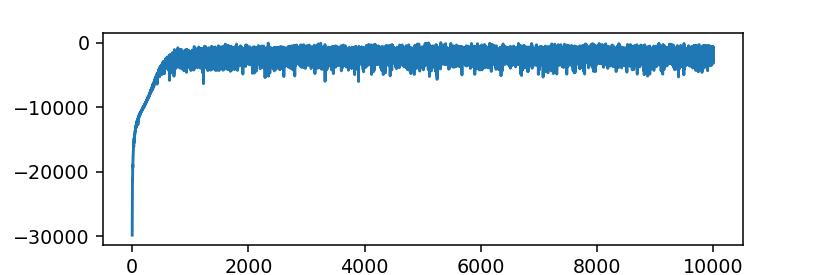

In [121]:
fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(logf)
plt.show()

In [12]:
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.07734397328038356
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,264.0121780455653
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.1835088486821176e-05
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,36.12873912064746
SVGP.kernel.kernels[2].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,2.1086041620255185
SVGP.kernel.kernels[2].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6495073886782866
SVGP.kernel.kernels[2].kernels[0].period,Parameter,Softplus,,False,(),float64,6.999999999999999
SVGP.kernel.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.5509171045607415
SVGP.kernel.kernels[2].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2005.4716296978095
SVGP.kernel.kernels[3].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.24970515002110236


In [122]:
data = pd.read_csv("birthdates-1968-1988.csv")
Xd = num2date(data.index.values)

## Figuras

In [15]:
f = m.predict_f_samples(Xt, full_cov=True, num_samples=10)

<IPython.core.display.Javascript object>


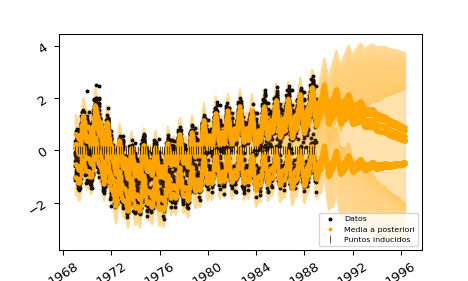

interactive(children=(FloatSlider(value=1.0, description='data alpha:', max=1.0), FloatSlider(value=4.0, descr…

In [16]:
n = 10001
Xt = np.round_(np.linspace(0, 10000, n)).astype(np.float64)[:, None]
mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

fig, ax = plt.subplots(1, figsize=(5, 3))
plt.title('Predicciones después de entrenar el modelo', fontsize=8)

def update_plot(da, ds, ms, ma, fa, fw):
    np.random.seed(0)
    ax.cla()
    ax.tick_params(labelrotation=33)
    ax.plot_date(Xd, Y, '.', label='Datos', alpha=da, markersize=ds, color='k')
    (mean,) = ax.plot(Xt[:-1], mpostc, '.', color='orange', markersize=ms, alpha=ma, label='Media a posteriori')
    col = mean.get_color()
    ax.plot(Xt[:-1, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col)
    ax.plot(Xt[:-1, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col) 
    
    ax.fill_between(Xt[:-1, 0],
                    (mpostc - 2 * spostc ** 0.5)[:, 0],
                    (mpostc + 2 * spostc ** 0.5)[:, 0],
                    color = col,
                    alpha = fa, 
                    lw = fw)
    
    
#     for i in range(0, 30):  #'num_samples'
#         ax.plot(Xt[:-1] , f[i, 1:, :], 'b-', alpha=0.15, lw=1.5)
        
    ax.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
    ax.legend(loc='lower right', fontsize=6)
    



da = widgets.FloatSlider(min=0, max=1, value=1, description='data alpha:')
ds = widgets.FloatSlider(min=0, max=4, value=4, description='data size:')
ms = widgets.FloatSlider(min=0, max=4, value=4, description='mean size:')
ma = widgets.FloatSlider(min=0, max=1, value=1, description='mean alpha:')
fw = widgets.FloatSlider(min=0, max=4, value=0.5, description='fill size:')
fa = widgets.FloatSlider(min=0, max=1, value=0.33, description='fill alpha:')


widgets.interactive(update_plot, 
                    da=da, 
                    ds=ds,
                    ms=ms, 
                    ma=ma, 
                    fa=fa, 
                    fw=fw)

<IPython.core.display.Javascript object>


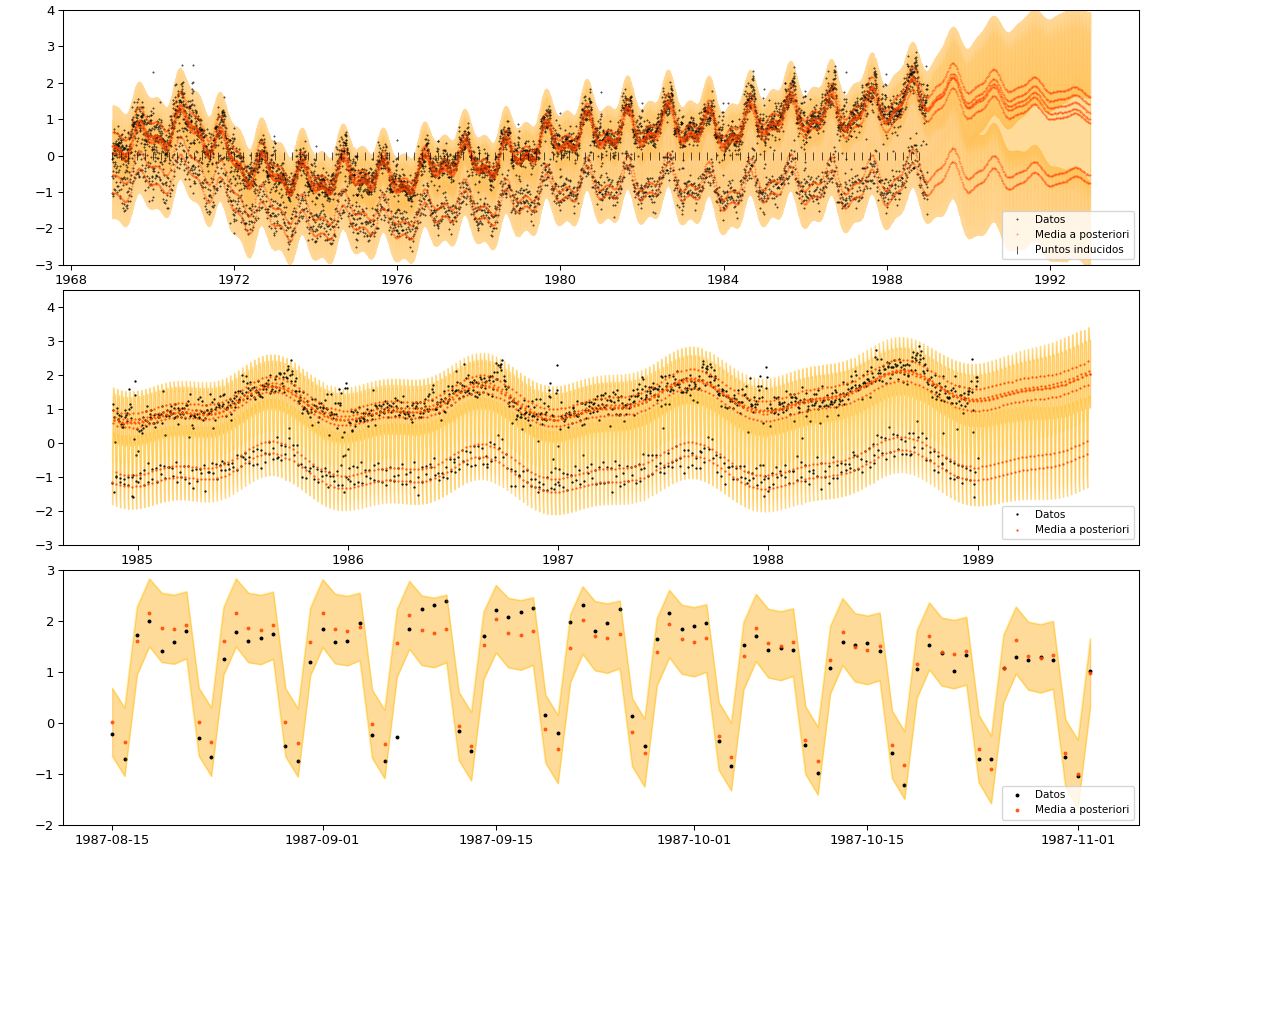

(-2.0, 3.0)

In [17]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(3, 1, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.05, hspace=0.1)

fig = plt.figure(0, figsize=(13.5, 11))
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0])

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, '.', label='Datos', alpha=1, markersize=0.8, color='k')
(mean,) = ax1.plot(Xt, mpostc, '.', color='orangered', markersize=0.7, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
# ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(-3,4)

k, t = 1700, 5800
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=1.5, color='k')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=1.5, alpha=0.9, label='Media a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax2.set_yticks([])
ax2.legend(loc='lower right', fontsize=8)
ax2.set_ylim(-3,4.5)

k, t = 80,6800
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=4, color='k')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=4, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax3.set_yticks([])
ax3.legend(loc='lower right', fontsize=8)
ax3.set_ylim(-2,3)

#fig.savefig('model.png', dpi=200) 

In [156]:
from matplotlib.ticker import FormatStrFormatter

<IPython.core.display.Javascript object>


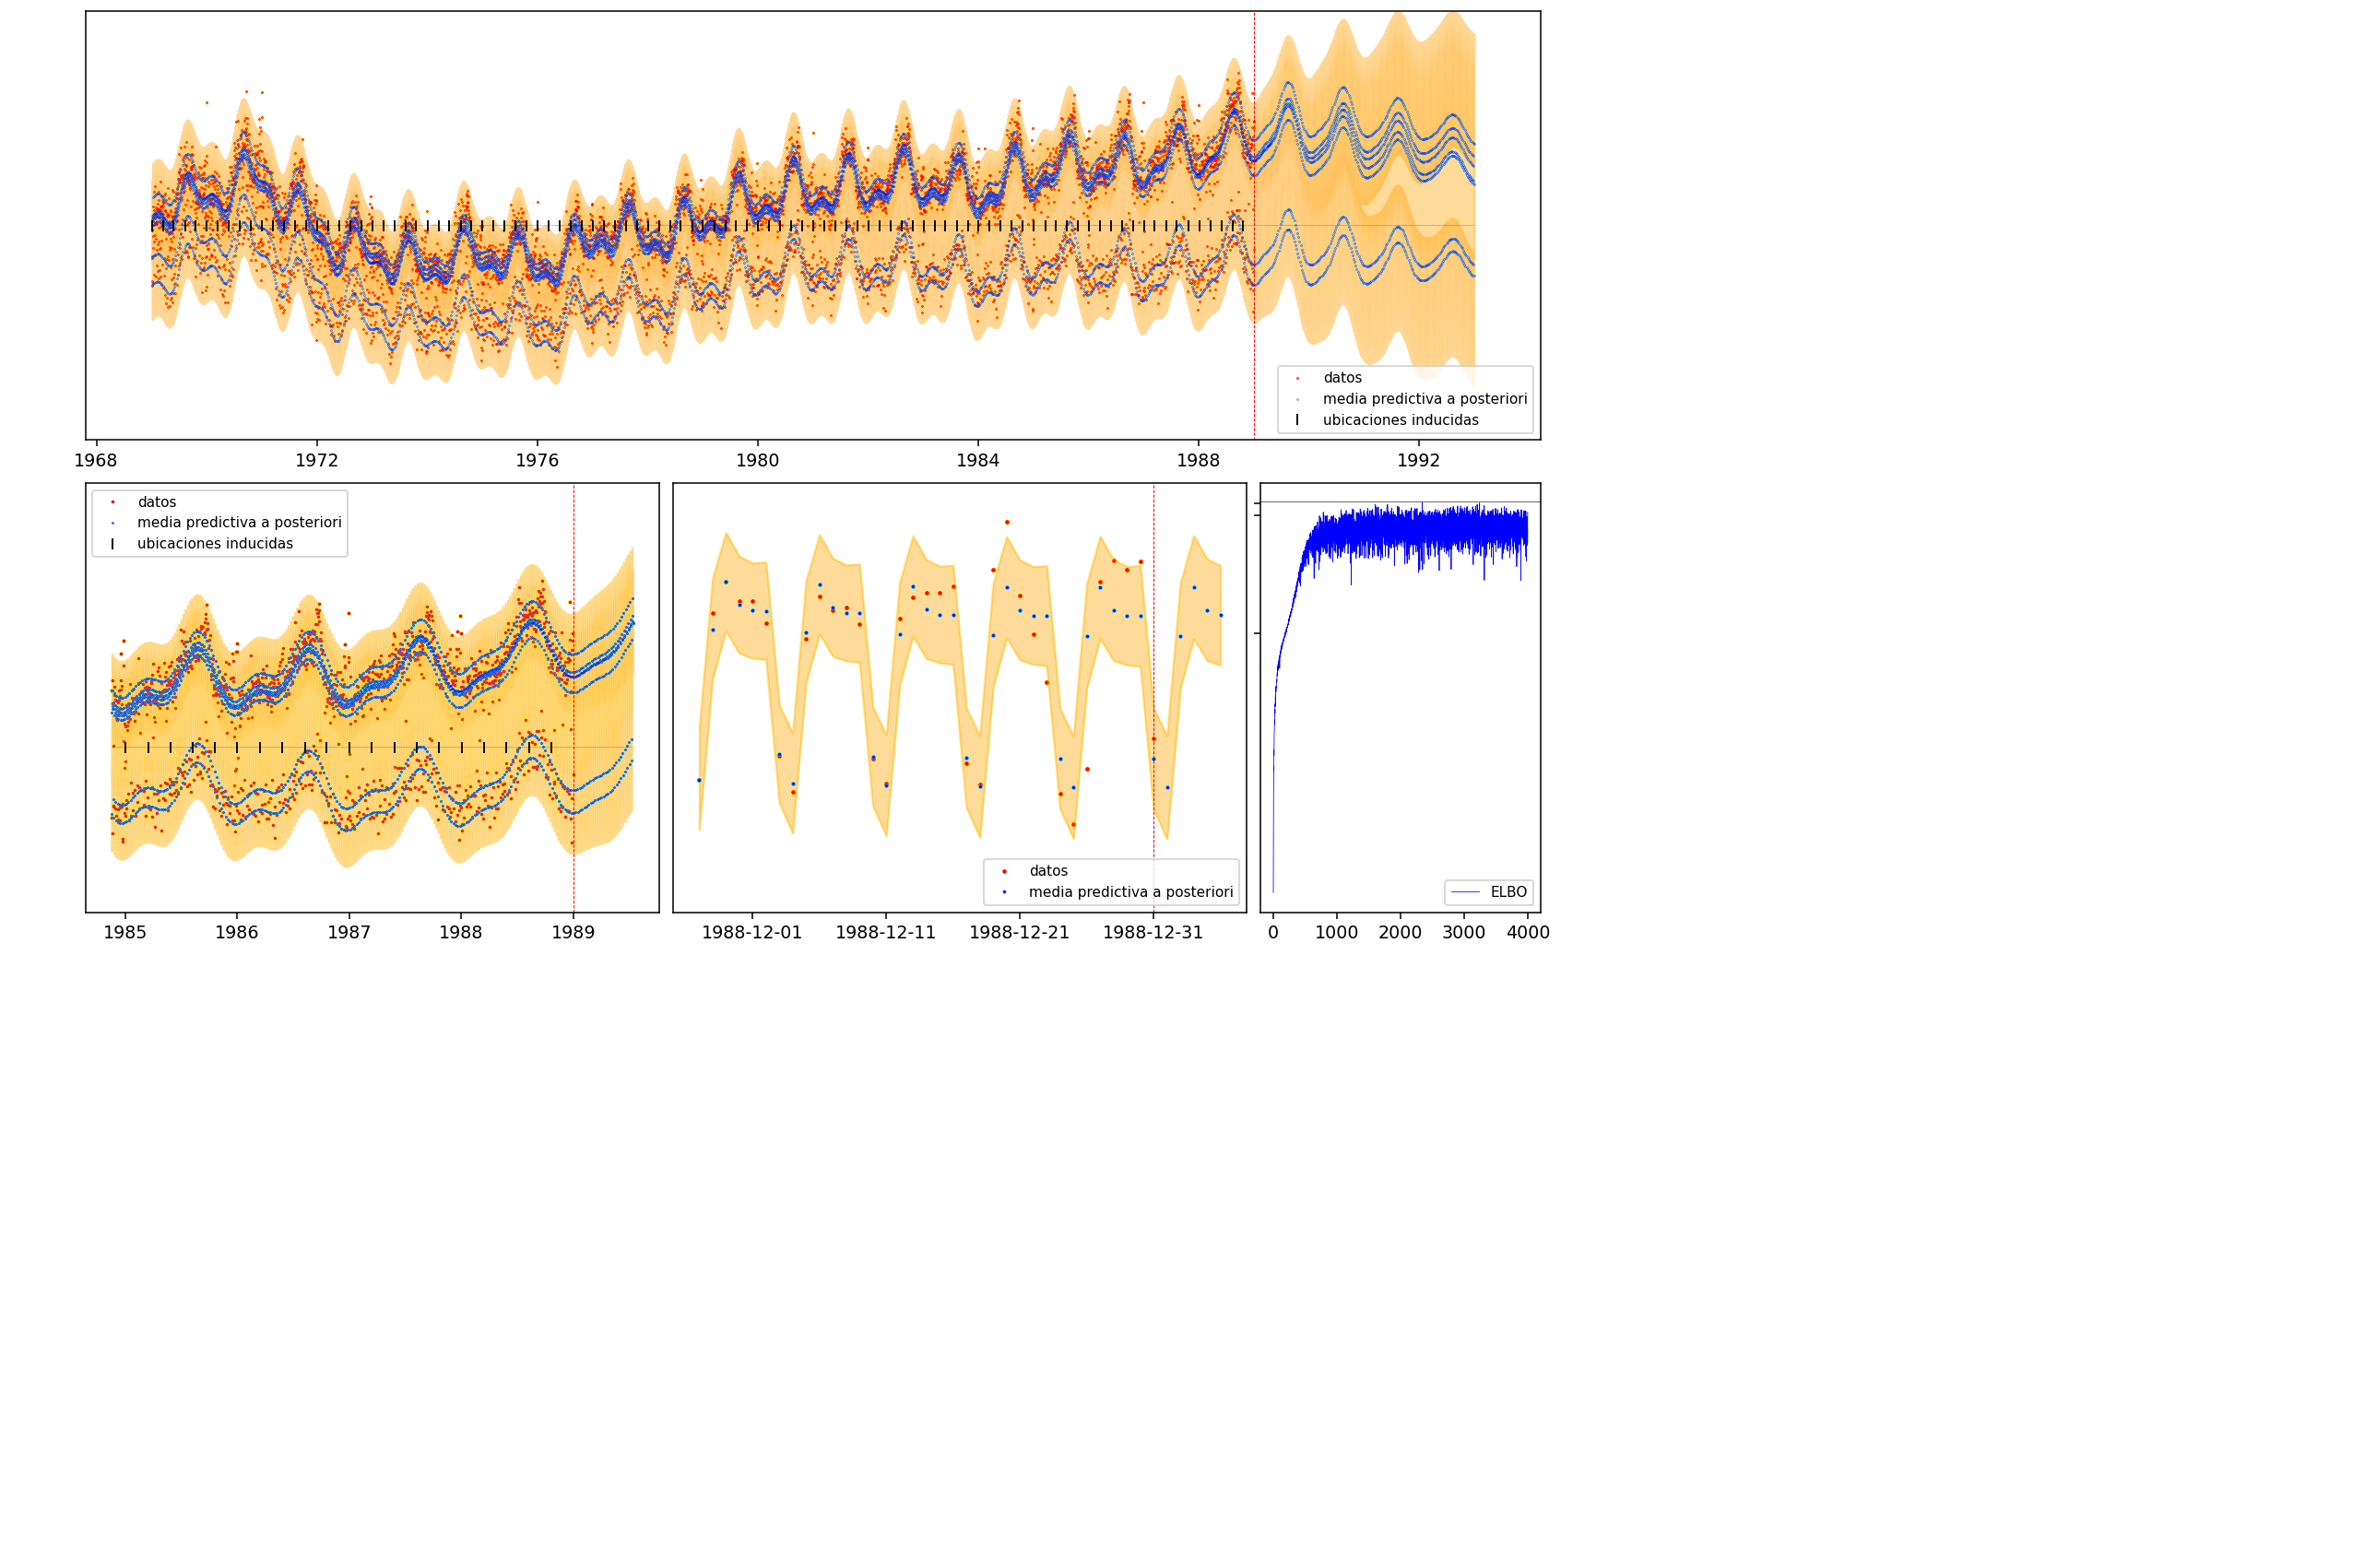

In [174]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(2, 5, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.05, hspace=0.1)

fig = plt.figure(0, figsize=(13.5, 9))
#fig = plt.figure(0, figsize=(8, 5))

ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :2])
ax3 = fig.add_subplot(grid[1, 2:4])
ax4 = fig.add_subplot(grid[1, 4])

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, 'o', alpha=1, markersize=0.7, color='yellow')
ax1.plot_date(Xd, Y, '.', label='datos', alpha=1, markersize=0.8, color='r')
(mean,) = ax1.plot(Xt, mpostc, '.', color='cyan', markersize=0.5, alpha=0.8)
(mean,) = ax1.plot(Xt, mpostc, '.', color='blue', markersize=0.4, alpha=1, label='media predictiva a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'k|', mew=1, label='ubicaciones inducidas')
ax1.plot(Xt, np.zeros_like(Xt), 'k-', lw=0.1)
ax1.legend(loc='lower right', fontsize=8)
ax1.axvline(x=7304, ymin=-1, ymax=1, ls='--', lw=0.5, color='red')
ax1.set_ylim(-4,4)

k, t = 1700, 5800
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], 'o', alpha=1, markersize=1.6, color='yellow')
ax2.plot_date(Xd[t:k+t], Y[t:k+t], 'o', label='datos', alpha=1, markersize=0.9, color='crimson')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='cyan', markersize=1.4, alpha=0.9)
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='blue', markersize=0.8, alpha=0.9, label='media predictiva a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
ax2.set_yticks([])

ax2.plot(Z[80:], np.zeros_like(Z[80:]), 'k|', mew=1, label='ubicaciones inducidas')
ax2.plot(Xt[t:k+t,0], np.zeros_like(Xt[t:k+t,0]), 'k-', lw=0.1)
ax2.legend(loc='upper left', fontsize=8)
ax2.axvline(x=7304, ymin=0, ymax=1, ls='--', lw=0.5, color='red')
ax2.set_ylim(-2.8,4.5)

k, t = 40,7270
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], 'o', alpha=1, markersize=2, color='yellow')
ax3.plot_date(Xd[t:k+t], Y[t:k+t], 'o', label='datos', alpha=1, markersize=1.4, color='r')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='cyan', markersize=3, alpha=0.8)
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='blue', markersize=2, alpha=0.8, label='media predictiva a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
ax3.set_yticks([])
ax3.set_xticks(['1988-12-01', '1988-12-11', '1988-12-21', '1988-12-31'])
ax3.legend(loc='lower right', fontsize=8)
ax3.axvline(x=7304, ymin=0, ymax=1, ls='--', lw=0.5, color='red')
ax3.set_ylim(-2.8,3)

ax4.plot(logf[:4000], color='blue', lw=0.4, label='ELBO')
ax4.axhline(0, ls='-', lw=0.3, color='k')
ax4.set_yticks([-1e2, -1e3, -1e4])
# ax4.yaxis.set_major_formatter(FormatStrFormatter('%2i'))
ax4.tick_params(axis='y', labelleft=False, labelright=False, left=True, right=False)
ax4.legend(loc='lower right', fontsize=8)
fig.savefig('modelelbo.png', dpi=200) 